In [39]:
import pandas as pd 
import numpy as np 
import os 
import re 

import spacy
import nltk

from collections import defaultdict 
from tqdm import tqdm 
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords

import plotly.graph_objects as go
import plotly.express as px 

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE 
sns.set()

In [36]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/timcha/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/timcha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/timcha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
import pymorphy2 
morph = pymorphy2.MorphAnalyzer()

In [6]:
# nlp = spacy.load("ru_core_news_sm")
# nlp

In [2]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [4]:
characters = defaultdict(lambda: defaultdict(int))
names2dict = {} 

In [11]:
# def spacy_get_names(paragraph):
#     doc = nlp(paragraph[3:-4]) 
    
#     if doc.ents:
#         pers = [] 
#         for entity in doc.ents:
#             if entity.label_ == 'PER':
#                 pers.append(entity.text)

#         if len(pers) > 1: 
#             for i in range(len(pers)): 
#                 for j in range(i + 1, len(pers)): 
#                     if pers[i] == pers[j]: 
#                         continue

#                     characters[pers[i]][pers[j]] += 1 
#                     characters[pers[j]][pers[i]] += 1

In [7]:
def natasha_get_names(paragraph):
    doc = Doc(paragraph)
    doc.segment(segmenter) 
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    for span in doc.spans:
        span.normalize(morph_vocab)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        
    for span in doc.spans:
        if span.type == PER:
            span.extract_fact(names_extractor) 
            

    names_dict = {_.normal: _.fact.as_dict for _ in doc.spans if _.fact} 
    names = list(names_dict.keys()) 
    
    if len(names) > 1: 
        for i in range(len(names_dict)):
            # здесь делаем маппинг от полного имени к имени и фамилии, извлеченных Наташей
            splitted_name = names_dict[names[i]]
            
            if names[i] not in names2dict: 
                first_name = splitted_name['first'] if 'first' in splitted_name else None 
                last_name = splitted_name['last'] if 'last' in splitted_name else None 
                
                names2dict[names[i]] = [first_name, last_name] 
                
            # здесь просто считаем матрицу связей персонажей
            for j in range(i + 1, len(names_dict)):
                if names[i] != names[j]: 
                    characters[names[i]][names[j]] += 1 
                    characters[names[j]][names[i]] += 1 

In [8]:
for book in os.listdir(): 
    if not book.endswith('.txt') or book == '1952 - Механическое пианино.txt': 
        continue 
    
    with open(book, mode='r', encoding='utf-8') as f: 
        text = f.readlines() 
        
        for paragraph in tqdm(text):
            if paragraph.strip().startswith('<p>'):
                natasha_get_names(paragraph[3:-4])

100%|██████████████████████████████████████| 2688/2688 [00:23<00:00, 114.85it/s]


In [70]:
tmp = pd.DataFrame(characters)

In [71]:
tmp = tmp.reset_index() 
tmp.head()

index  Юджин Дебс Хартке  Бенджамен Уиллс  Юджин Дебса  Дебсом  \
0    Бенджамен Уиллс                1.0              NaN          1.0     1.0   
1        Юджин Дебса                1.0              1.0          NaN     NaN   
2             Мелани                1.0              NaN          NaN     NaN   
3      Юджин Младший                1.0              NaN          NaN     NaN   
4  Юджин Дебс Хартке                NaN              1.0          1.0     NaN   

   Аарон Таркингтон  Карл Великий  Шекспир  Аарон  Элиас  ...  \
0               NaN           NaN      NaN    NaN    NaN  ...   
1               NaN           NaN      NaN    NaN    NaN  ...   
2               NaN           NaN      NaN    NaN    NaN  ...   
3               NaN           NaN      NaN    NaN    NaN  ...   
4               NaN           NaN      NaN    NaN    NaN  ...   

   Бенджамен Гаррисона  Тони Уэйнрайт  Диана Луун Ламперс  Раймонд Бойль  \
0                  NaN            NaN                 NaN            NaN   
1                  NaN            NaN                 NaN            NaN   
2                  NaN            NaN                 NaN            NaN   
3                  NaN            NaN                 NaN            NaN   
4                  NaN            NaN                 NaN            NaN   

   Ганс Румпф  Пью-ти-фьют  Питер Лоуфорд  Ф. Скотт Фицджеральд  Мистер Траут  \
0         NaN          NaN            NaN                   NaN           NaN   
1         NaN          NaN            NaN                   NaN           NaN   
2         NaN          NaN            NaN                   NaN           NaN   
3         NaN          NaN            NaN                   NaN           NaN   
4         NaN          NaN            NaN                   NaN           NaN   

   Мистер Мак-Алистер  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 2470 columns]

In [11]:
tmp.columns = ['Персонаж'] + list(tmp.columns[1:])

In [12]:
tmp['sum'] = tmp.sum(axis=1)

/tmp/ipykernel_7589/2938568051.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tmp['sum'] = tmp.sum(axis=1)


In [14]:
filtered = tmp[tmp['sum'] >= 10]
filtered

Персонаж  Юджин Дебс Хартке  Бенджамен Уиллс  Юджин Дебса  Дебсом  \
6     Карл Великий                NaN              NaN          NaN     NaN   
7          Шекспир                NaN              NaN          NaN     NaN   
15          Золтан                NaN              NaN          NaN     NaN   
16           Иисус                NaN              NaN          NaN     NaN   
18           Иосиф                NaN              NaN          NaN     NaN   
...            ...                ...              ...          ...     ...   
2300          О.Г.                NaN              NaN          NaN     NaN   
2301          Н.Е.                NaN              NaN          NaN     NaN   
2302          Б.О.                NaN              NaN          NaN     NaN   
2303          И.З.                NaN              NaN          NaN     NaN   
2304     Е.М, Л.Ю.                NaN              NaN          NaN     NaN   

      Аарон Таркингтон  Карл Великий  Шекспир  Аарон  Элиас  ...  \
6                  1.0           NaN      1.0    NaN    NaN  ...   
7                  1.0           1.0      NaN    NaN    NaN  ...   
15                 NaN           1.0      NaN    NaN    NaN  ...   
16                 NaN           1.0      NaN    NaN    NaN  ...   
18                 NaN           1.0      NaN    NaN    NaN  ...   
...                ...           ...      ...    ...    ...  ...   
2300               NaN           NaN      NaN    NaN    NaN  ...   
2301               NaN           NaN      NaN    NaN    NaN  ...   
2302               NaN           NaN      NaN    NaN    NaN  ...   
2303               NaN           NaN      NaN    NaN    NaN  ...   
2304               NaN           NaN      NaN    NaN    NaN  ...   

      Тони Уэйнрайт  Диана Луун Ламперс  Раймонд Бойль  Ганс Румпф  \
6               NaN                 NaN            NaN         NaN   
7               NaN                 NaN            NaN         NaN   
15              NaN                 NaN            NaN         NaN   
16              NaN                 NaN            NaN         NaN   
18              NaN                 NaN            NaN         NaN   
...             ...                 ...            ...         ...   
2300            NaN                 NaN            NaN         NaN   
2301            NaN                 NaN            NaN         NaN   
2302            NaN                 NaN            NaN         NaN   
2303            NaN                 NaN            NaN         NaN   
2304            NaN                 NaN            NaN         NaN   

      Пью-ти-фьют  Питер Лоуфорд  Ф. Скотт Фицджеральд  Мистер Траут  \
6             NaN            NaN                   NaN           NaN   
7             NaN            NaN                   NaN           NaN   
15            NaN            NaN                   NaN           NaN   
16            NaN            NaN                   NaN           NaN   
18            NaN            NaN                   NaN           NaN   
...           ...            ...                   ...           ...   
2300          NaN            NaN                   NaN           NaN   
2301          NaN            NaN                   NaN           NaN   
2302          NaN            NaN                   NaN           NaN   
2303          NaN            NaN                   NaN           NaN   
2304          NaN            NaN                   NaN           NaN   

      Мистер Мак-Алистер   sum  
6                    NaN  10.0  
7                    NaN  18.0  
15                   NaN  28.0  
16                   NaN  24.0  
18                   NaN  10.0  
...                  ...   ...  
2300                 NaN  12.0  
2301                 NaN  12.0  
2302                 NaN  12.0  
2303                 NaN  12.0  
2304                 NaN  12.0  

[328 rows x 2471 columns]

In [16]:
# выкидываем все лишние колонки

names = persons_filtered['Персонаж'] 
all_names = persons_filtered.columns[1:-1]

_ = persons_filtered.drop(columns=list(set(all_names) - set(names)))
_

Персонаж  Карл Великий  Шекспир  Авраам Линкольн  Лоурел  Харди  \
6     Карл Великий           0.0      1.0              0.0     0.0    0.0   
7          Шекспир           1.0      0.0              0.0     0.0    0.0   
15          Золтан           1.0      0.0              0.0     0.0    0.0   
16           Иисус           1.0      0.0              0.0     0.0    0.0   
18           Иосиф           1.0      0.0              0.0     0.0    0.0   
...            ...           ...      ...              ...     ...    ...   
2300          О.Г.           0.0      0.0              0.0     0.0    0.0   
2301          Н.Е.           0.0      0.0              0.0     0.0    0.0   
2302          Б.О.           0.0      0.0              0.0     0.0    0.0   
2303          И.З.           0.0      0.0              0.0     0.0    0.0   
2304     Е.М, Л.Ю.           0.0      0.0              0.0     0.0    0.0   

      Маргарет  Джек  Элтон Дарвин  Дарвин  ...  Каролина Розуотер  Аманита  \
6          0.0   0.0           0.0     0.0  ...                0.0      0.0   
7          0.0   0.0           0.0     1.0  ...                0.0      0.0   
15         0.0   0.0           0.0     0.0  ...                0.0      0.0   
16         0.0   0.0           0.0     0.0  ...                0.0      0.0   
18         0.0   0.0           0.0     0.0  ...                0.0      0.0   
...        ...   ...           ...     ...  ...                ...      ...   
2300       0.0   0.0           0.0     0.0  ...                0.0      0.0   
2301       0.0   0.0           0.0     0.0  ...                0.0      0.0   
2302       0.0   0.0           0.0     0.0  ...                0.0      0.0   
2303       0.0   0.0           0.0     0.0  ...                0.0      0.0   
2304       0.0   0.0           0.0     0.0  ...                0.0      0.0   

      Стюарт  Бантлайн  Зайка  Аманиты  Джон Розуотер  Чарли  Ноис   sum  
6        0.0       0.0    0.0      0.0            0.0    0.0   0.0  10.0  
7        0.0       0.0    0.0      0.0            0.0    0.0   0.0  18.0  
15       0.0       0.0    0.0      0.0            0.0    0.0   0.0  28.0  
16       0.0       0.0    0.0      0.0            0.0    0.0   0.0  24.0  
18       0.0       0.0    0.0      0.0            0.0    0.0   0.0  10.0  
...      ...       ...    ...      ...            ...    ...   ...   ...  
2300     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
2301     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
2302     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
2303     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
2304     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  

[328 rows x 330 columns]

In [55]:
# _.to_csv('vonnegut_graph_ver_1(rubbish).csv', index=False)

## Визуализируем граф

In [31]:
characters_graph = pd.read_csv('vonnegut_graph_ver_1(rubbish).csv') 
characters_graph

Персонаж  Карл Великий  Шекспир  Авраам Линкольн  Лоурел  Харди  \
0    Карл Великий           0.0      1.0              0.0     0.0    0.0   
1         Шекспир           1.0      0.0              0.0     0.0    0.0   
2          Золтан           1.0      0.0              0.0     0.0    0.0   
3           Иисус           1.0      0.0              0.0     0.0    0.0   
4           Иосиф           1.0      0.0              0.0     0.0    0.0   
..            ...           ...      ...              ...     ...    ...   
323          О.Г.           0.0      0.0              0.0     0.0    0.0   
324          Н.Е.           0.0      0.0              0.0     0.0    0.0   
325          Б.О.           0.0      0.0              0.0     0.0    0.0   
326          И.З.           0.0      0.0              0.0     0.0    0.0   
327     Е.М, Л.Ю.           0.0      0.0              0.0     0.0    0.0   

     Маргарет  Джек  Элтон Дарвин  Дарвин  ...  Каролина Розуотер  Аманита  \
0         0.0   0.0           0.0     0.0  ...                0.0      0.0   
1         0.0   0.0           0.0     1.0  ...                0.0      0.0   
2         0.0   0.0           0.0     0.0  ...                0.0      0.0   
3         0.0   0.0           0.0     0.0  ...                0.0      0.0   
4         0.0   0.0           0.0     0.0  ...                0.0      0.0   
..        ...   ...           ...     ...  ...                ...      ...   
323       0.0   0.0           0.0     0.0  ...                0.0      0.0   
324       0.0   0.0           0.0     0.0  ...                0.0      0.0   
325       0.0   0.0           0.0     0.0  ...                0.0      0.0   
326       0.0   0.0           0.0     0.0  ...                0.0      0.0   
327       0.0   0.0           0.0     0.0  ...                0.0      0.0   

     Стюарт  Бантлайн  Зайка  Аманиты  Джон Розуотер  Чарли  Ноис   sum  
0       0.0       0.0    0.0      0.0            0.0    0.0   0.0  10.0  
1       0.0       0.0    0.0      0.0            0.0    0.0   0.0  18.0  
2       0.0       0.0    0.0      0.0            0.0    0.0   0.0  28.0  
3       0.0       0.0    0.0      0.0            0.0    0.0   0.0  24.0  
4       0.0       0.0    0.0      0.0            0.0    0.0   0.0  10.0  
..      ...       ...    ...      ...            ...    ...   ...   ...  
323     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
324     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
325     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
326     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  
327     0.0       0.0    0.0      0.0            0.0    0.0   0.0  12.0  

[328 rows x 330 columns]

In [77]:
import networkx as nx

G = nx.from_pandas_adjacency(characters_graph.set_index('Персонаж')) 
G.name = 'Kurt Vonnegut characters network'

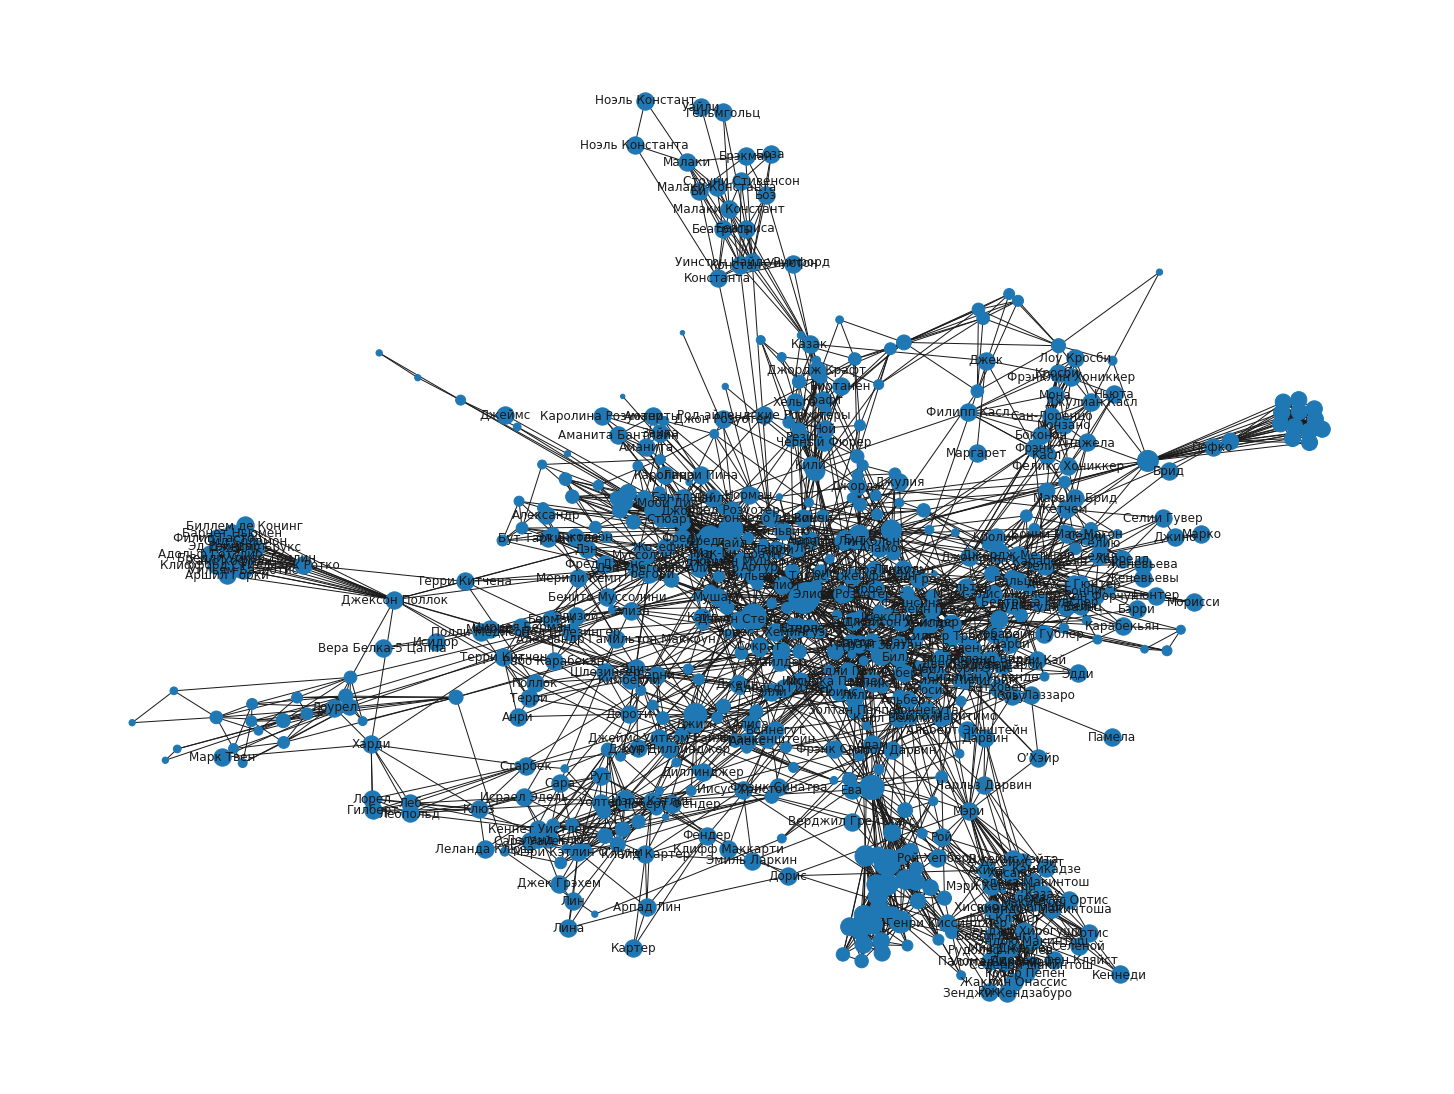

In [85]:
plt.figure(figsize=(20, 15))

d = dict(nx.degree(G))

nx.draw(G, nodelist=d.keys(), node_size=[v * 20 for v in d.values()])
nx.draw_networkx(G)

Такое себе. Попробуем pyvis

In [98]:
from pyvis.network import Network 

scale = 2.5

d = dict(G.degree)

#Updating dict
d.update((x, scale*y) for x, y in d.items())

#Setting up size attribute
nx.set_node_attributes(G, d, 'size')

net = Network(notebook=True) 
net.from_nx(G) 

In [99]:
net.show('characters_ver1.html')

characters_ver1.html


### Пытаемся улучшить собранные данные 

Как видно из предыдущих визуализаций, основная проблема заключается в том, что один и тот же персонаж может быть представлен несколькими вершинами из-за разных словоформ. Лемматизация, к сожалению, здесь не помогла. Тем более что нужно еще как-то соединять те упоминания персонажей, где в первом случае, например, фамилия, а во втором - имя. 

В данном пункте были всяческие попытки соединить упоминания персонажа в различных словоформах. Спойлер - ничего не получилось. Вкратце я пробовал два способа: 

1) Различные правила по сравнению имен персонажей. Тут было несколько вариантов, что-то попробовал, но толком додумать не смог. 

2) Word2Vec на всех текстах. Идея следующая - с помощью эмбеддингов можно будет по косинусной близости искать ближайших соседей, и потом как-то отбирать только те имена, что в начальной форме. 
Либо же попробовать кластеризовать, и в качестве основной формы имени персонажа брать центр кластера. 

In [33]:
df_first_last = pd.DataFrame(names2dict).T
df_first_last.columns = ['first', 'last'] 

df_first_last

first        last
Юджин Дебс Хартке         Юджин        Дебс
Бенджамен Уиллс       Бенджамен       Уиллс
Юджин Дебса               Юджин       Дебса
Дебсом                     None      Дебсом
Аарон Таркингтон          Аарон  Таркингтон
...                         ...         ...
Пью-ти-фьют                None          ти
Питер Лоуфорд             Питер     Лоуфорд
Ф. Скотт Фицджеральд          Ф       Скотт
Мистер Траут               None       Траут
Мистер Мак-Алистер         None         Мак

[2469 rows x 2 columns]

In [101]:
characters_graph.to_csv('vonnegut_characters_ver2.csv', index=False) 

In [32]:
# выкидываем инициалы, так как сложно определить к кому они относятся 

initials = characters_graph[characters_graph['Персонаж'].str.contains('.', regex=False)]['Персонаж'].values

characters_graph = characters_graph[~(characters_graph['Персонаж'].str.contains('.', regex=False))]
characters_graph = characters_graph.drop(columns=initials)

characters_graph.head()

Персонаж  Карл Великий  Шекспир  Авраам Линкольн  Лоурел  Харди  \
0  Карл Великий           0.0      1.0              0.0     0.0    0.0   
1       Шекспир           1.0      0.0              0.0     0.0    0.0   
2        Золтан           1.0      0.0              0.0     0.0    0.0   
3         Иисус           1.0      0.0              0.0     0.0    0.0   
4         Иосиф           1.0      0.0              0.0     0.0    0.0   

   Маргарет  Джек  Элтон Дарвин  Дарвин  ...  Каролина Розуотер  Аманита  \
0       0.0   0.0           0.0     0.0  ...                0.0      0.0   
1       0.0   0.0           0.0     1.0  ...                0.0      0.0   
2       0.0   0.0           0.0     0.0  ...                0.0      0.0   
3       0.0   0.0           0.0     0.0  ...                0.0      0.0   
4       0.0   0.0           0.0     0.0  ...                0.0      0.0   

   Стюарт  Бантлайн  Зайка  Аманиты  Джон Розуотер  Чарли  Ноис   sum  
0     0.0       0.0    0.0      0.0            0.0    0.0   0.0  10.0  
1     0.0       0.0    0.0      0.0            0.0    0.0   0.0  18.0  
2     0.0       0.0    0.0      0.0            0.0    0.0   0.0  28.0  
3     0.0       0.0    0.0      0.0            0.0    0.0   0.0  24.0  
4     0.0       0.0    0.0      0.0            0.0    0.0   0.0  10.0  

[5 rows x 312 columns]

In [76]:
characters_graph = characters_graph[characters_graph['Персонаж'] != 'Медичи'] 

### Обучаем w2v

Идея: можем в качестве  

In [40]:
alnum_regex = re.compile('\w+')

def find_words(text, regex = alnum_regex):
    tokens = regex.findall(text.lower())
    return [w for w in tokens if w.isalpha and len(w) > 3]

stopwords_set = set(stopwords.words('russian'))
stopwords_set.add('всё')
stopwords_set.add('это')
stopwords_set.add('мочь')
stopwords_set.add('очень')

def lemmatize(words, lemmer = morph, stopwords = stopwords_set):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords and w.isalpha()]

def preprocess(text):
    return (find_words(text))

In [48]:
preprocessed_texts = [] 

for book in os.listdir(): 
    if not book.endswith('.txt') or book == '1952 - Механическое пианино.txt': 
        continue 
    
    with open(book, mode='r', encoding='utf-8') as f: 
        text = f.readlines() 
        
        for paragraph in tqdm(text):
            if paragraph.strip().startswith('<p>'):
                preprocessed_texts.append(preprocess(paragraph))

100%|███████████████████████████████████| 2688/2688 [00:00<00:00, 105176.49it/s]


In [50]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=preprocessed_texts, vector_size=300, window=5, min_count=5, epochs=10)

In [54]:
model.wv.most_similar('траут')

[('констант', 0.8648024797439575),
 ('румфорд', 0.8359214663505554),
 ('двейн', 0.8306462168693542),
 ('элиот', 0.8101716041564941),
 ('дядёк', 0.8043066263198853),
 ('розуотер', 0.7856013774871826),
 ('фантаст', 0.7834746837615967),
 ('килгор', 0.7791305184364319),
 ('доктор', 0.7735216021537781),
 ('сенатор', 0.7397904992103577)]

#### Пытаемся кластеризовать 

In [69]:
chars = characters_graph['Персонаж'].apply(lambda x: x.lower()).values
chars[:10]

array(['карл великий', 'шекспир', 'золтан', 'иисус', 'иосиф', 'траут',
       'фред', 'линкольн', 'вольтер', 'артур'], dtype=object)

In [58]:
char2embedding = {} 

for char in chars: 
    parts = char.split() 
    
    emb = np.zeros(300)
    for part in parts:
        if part in model.wv: 
            emb += model.wv[part] 
        
    emb /= len(parts)
    char2embedding[char] = emb 

In [65]:
char2embedding_reducted = TSNE(n_components=2, learning_rate=100, init='random').fit_transform(np.array(list(char2embedding.values())))

In [68]:
px.scatter(x=char2embedding_reducted[:, 0], 
           y=char2embedding_reducted[:, 1], 
           text=chars, 
           title='Dimension reduced characters embeddings')

В целом выглядит норм, но проблемы все равно остались - непонятно как выбирать нужную форму имени. 

К тому же косинусная близость для многих персонажей оказалась не очень репрезентативной, так как ближе всего находятся не другие словоформы имени персонажа, а имена персонажей, которые часто взаимодействует с ним. 